In [1]:

from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)
    def compile(self, optimizer, loss, metrics):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


class Meso1(Classifier):
    """
    Feature extraction + Classification
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)


class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define image data generator with rescaling
data_generator = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 16

# Create train and validation generators
train_generator = data_generator.flow_from_directory(
    'D:/PROJECT/DATASET/deepfake_database/deepfake_database/train_test',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',  # Assumes binary classification
    subset='training'
)

valid_generator = data_generator.flow_from_directory(
    'D:/PROJECT/DATASET/deepfake_database/deepfake_database/validation',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',  # Assumes binary classification
    subset='training'
)



Found 12353 images belonging to 2 classes.
Found 7104 images belonging to 2 classes.


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Instantiate the MesoInception4 model
meso_inception4_model = MesoInception4()

# Compile the model
meso_inception4_model.compile(optimizer=Adam(lr=0.001),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

# Define a model checkpoint callback
checkpoint_path = "meso_inception4_best_weights.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = meso_inception4_model.model.fit(
    train_generator,
    epochs=8,
    validation_data=valid_generator,
    callbacks=[checkpoint]
)

# Load the best weights back into the model
meso_inception4_model.model.load_weights(checkpoint_path)


Epoch 1/8
773/773 [==============================] - 97s 109ms/step - loss: 0.5608 - accuracy: 0.7284 - val_loss: 0.3942 - val_accuracy: 0.8626
Epoch 2/8
773/773 [==============================] - 42s 55ms/step - loss: 0.3549 - accuracy: 0.8431 - val_loss: 0.3615 - val_accuracy: 0.8464
Epoch 3/8
773/773 [==============================] - 60s 77ms/step - loss: 0.2681 - accuracy: 0.8858 - val_loss: 0.3988 - val_accuracy: 0.8302
Epoch 4/8
773/773 [==============================] - 43s 55ms/step - loss: 0.2160 - accuracy: 0.9101 - val_loss: 0.3353 - val_accuracy: 0.8626
Epoch 5/8
773/773 [==============================] - 44s 57ms/step - loss: 0.1936 - accuracy: 0.9233 - val_loss: 0.2387 - val_accuracy: 0.9017
Epoch 6/8
773/773 [==============================] - 42s 54ms/step - loss: 0.1751 - accuracy: 0.9324 - val_loss: 0.2506 - val_accuracy: 0.8992
Epoch 7/8
773/773 [==============================] - 42s 54ms/step - loss: 0.1477 - accuracy: 0.9425 - val_loss: 0.3155 - val_accuracy: 0.881

In [5]:

# Save the entire model
meso_inception4_model.model.save("D:/PROJECT/DATASET/trainedmodels/meso_inception4_model.h5")

In [6]:
# Evaluate the model on the validation set
eval_result = meso_inception4_model.model.evaluate(valid_generator)

# Display the evaluation results
print("Validation Loss:", eval_result[0])
print("Validation Accuracy:", eval_result[1])


444/444 [==============================] - 10s 21ms/step - loss: 0.2387 - accuracy: 0.9017
Validation Loss: 0.23871366679668427
Validation Accuracy: 0.9017454981803894


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image for testing
test_image_path = 'D:/PROJECT/DATASET/1000dataset/validation/df/df01181.jpg'  # Replace with the path to your test image
img = image.load_img(test_image_path, target_size=(256, 256))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess the input image
img_array /= 255.0

# Make predictions
prediction = meso_inception4_model.model.predict(img_array)

# Display the prediction result
if prediction[0, 0] >= 0.5:
    print("Prediction: Real")
else:
    print("Prediction: Deepfake")


Prediction: Deepfake


Found 7104 images belonging to 2 classes.
444/444 [==============================] - 73s 164ms/step - loss: 0.3075 - accuracy: 0.8653


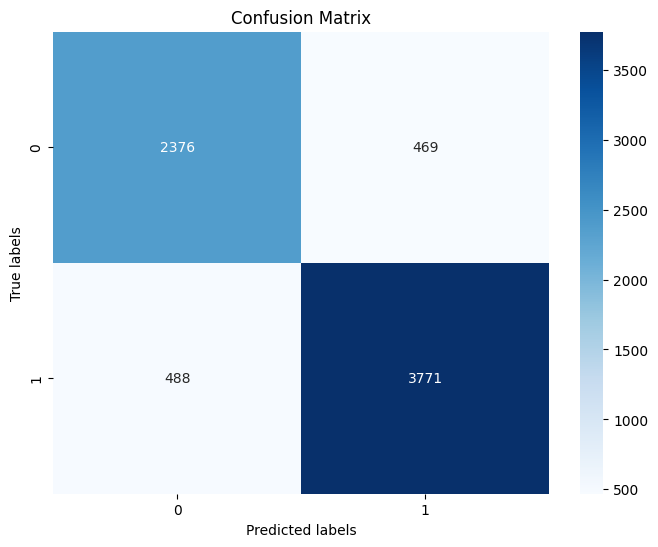

F1 Score: 0.8873985174726439


In [9]:
from tensorflow.keras.models import load_model

# Load the trained model
meso_inception4_model = load_model("C:\\Users\\user\\MAIN PROJECT\\meso_inception4_best_weights.h5")

# Define image data generator with rescaling
data_generator = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 16

# Load the validation data
valid_generator = data_generator.flow_from_directory(
    'D:/PROJECT/DATASET/deepfake_database/deepfake_database/validation',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',  # Assumes binary classification
    shuffle=False  # Ensure the order is retained for evaluation
)

# Evaluate the model on the validation data
val_loss, val_accuracy = meso_inception4_model.evaluate(valid_generator)

# Get the predictions on the validation data
y_pred_prob = meso_inception4_model.predict(valid_generator)
y_pred_classes = np.round(y_pred_prob).flatten().astype(int)

# Get the ground truth labels
y_true = valid_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Display F1 score
print("F1 Score:", f1)


In [7]:
# Print confusion matrix as text
print("Confusion Matrix:")
print(conf_matrix)

# Display F1 score
print("F1 Score:", f1)


Confusion Matrix:
[[2376  469]
 [ 488 3771]]
F1 Score: 0.8873985174726439


In [8]:
from tensorflow.keras.models import load_model

# Load the trained model
meso_inception4_model = load_model("C:\\Users\\user\\MAIN PROJECT\\meso_inception4_best_weights.h5")
# Load the validation data
valid_generator = data_generator.flow_from_directory(
    r"D:\PROJECT\dfdata\dataf\val",
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',  # Assumes binary classification
    shuffle=False  # Ensure the order is retained for evaluation
)

# Evaluate the model on the validation data
eval_result = meso_inception4_model.evaluate(valid_generator)

# Display the evaluation results
print("Validation Loss:", eval_result[0])
print("Validation Accuracy:", eval_result[1])

# Get the predictions on the validation data
y_pred_prob = meso_inception4_model.predict(valid_generator)
y_pred_classes = np.round(y_pred_prob).flatten().astype(int)

# Get the ground truth labels
y_true = valid_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes)

# Print confusion matrix as text
print("Confusion Matrix:")
print(conf_matrix)

# Display F1 score
print("F1 Score:", f1)


Found 7170 images belonging to 2 classes.
449/449 [==============================] - 105s 234ms/step - loss: 1.2265 - accuracy: 0.6583
Validation Loss: 1.2264584302902222
Validation Accuracy: 0.6582984924316406
Confusion Matrix:
[[2747 2344]
 [ 106 1973]]
F1 Score: 0.6169480925578487
